# 05 - Evaluación Final en Test Set

En este notebook se realiza la **evaluación final del modelo ganador**  
identificado en el análisis comparativo anterior (`04_ModelComparison.ipynb`).

📊 **Objetivos:**
- Importar las librerías necesarias.  
- Cargar los datasets de test desde `../data/processed/`.  
- Leer el modelo ganador indicado en `model_comparison_summary.csv`.  
- Evaluar su rendimiento sobre el **Test Set Final**.  
- Calcular las métricas de clasificación:  
  **Accuracy, Precision, Recall, F1-score, ROC-AUC**.  
- Visualizar la **matriz de confusión** y la **curva ROC**.  
- Confirmar la robustez del modelo y su capacidad de generalización.
- Guardar los resultados finales en formato `.json`.  


📁 Archivos de entrada esperados:

- Datasets procesados en `../data/processed/`
- CSV de la comparación de modelos: `model_comparison_summary.csv`


- Modelo entrenado y guardado (`.pkl`) del mejor algoritmo


## **Paso 1: Importar librerías**


In [29]:
# ===================================
# 1. Importar librerías necesarias
# ===================================

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

from IPython.display import Markdown, display
import warnings



# Configuración visual general de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

print("✅ Librerías importadas correctamente.")


✅ Librerías importadas correctamente.


## **Paso 2: Cargar datasets y modelo ganador**

In [30]:
# ===================================
# 2. Cargar dataset final y modelo ganador
# ===================================

# Rutas de archivos
data_path = "../data/processed/"
results_path = "../reports/results/"
models_path = "../models/"

# --- Cargar datasets procesados ---
X_test_scaled = pd.read_csv(f"{data_path}X_test_scaled.csv")
y_test = pd.read_csv(f"{data_path}y_test.csv").squeeze()

# Convertir y_test a tipo numérico por seguridad (0 = insatisfecho, 1 = satisfecho)
y_test = y_test.astype(int)

print(f"✅ Dataset cargado correctamente.")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True) * 100}\n")

# --- Cargar comparación de modelos ---
comparison_df = pd.read_csv(f"{data_path}model_comparison_summary.csv")

# Normalizar nombres de columnas
comparison_df.columns = (
    comparison_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Asegurar columna de puntuación promedio
if "mean_score" not in comparison_df.columns:
    metric_cols = ["accuracy", "precision", "recall", "f1-score", "roc-auc"]
    comparison_df["mean_score"] = comparison_df[metric_cols].mean(axis=1)

# --- Detectar el modelo ganador ---
best_model_name = comparison_df.loc[comparison_df["mean_score"].idxmax(), "model"]
display(Markdown(f"### 🏆 Modelo ganador: **{best_model_name}**"))

# --- Cargar modelo entrenado ---
model_filename = f"{best_model_name.lower().replace(' ', '_')}_model.pkl"
model_path = f"{models_path}{model_filename}"

best_model = joblib.load(model_path)
display(Markdown(f"✅ Modelo cargado correctamente desde `{model_path}`"))


✅ Dataset cargado correctamente.
X_test_scaled shape: (20781, 23)
y_test distribution:
satisfaction
0    56.667148
1    43.332852
Name: proportion, dtype: float64



### 🏆 Modelo ganador: **Random Forest**

✅ Modelo cargado correctamente desde `../models/random_forest_model.pkl`

## **Paso 3: Evaluación del modelo ganador sobre el Test Set Final**

En este paso evaluamos el **modelo ganador** (según las métricas medias)  
utilizando el conjunto de prueba final (`X_test_scaled`, `y_test`).

Se calculan las principales métricas de clasificación y se visualizan:

- **Matriz de confusión** → muestra la calidad de las predicciones por clase.  
- **Curva ROC** → evalúa la capacidad del modelo para distinguir entre clases.  
- **Reporte de clasificación** → resume métricas de precisión, recall y F1-score.

Esto nos permite verificar si el rendimiento del modelo en el test set  
se mantiene coherente con los resultados obtenidos durante la validación cruzada.


### 📊 **Métricas de rendimiento en el Test Set Final**

Accuracy: 0.962
Precision: 0.964
Recall: 0.946
F1-score: 0.955
ROC-AUC: 0.994


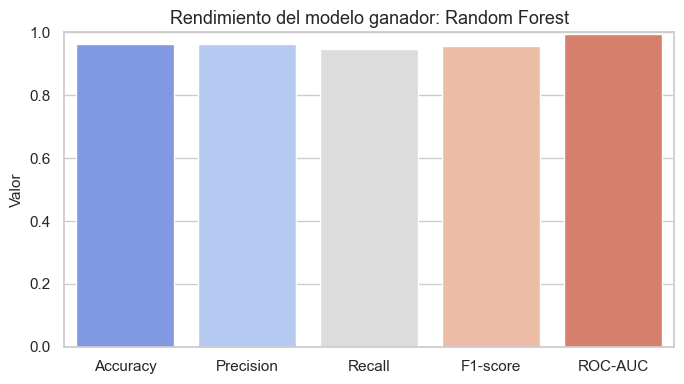

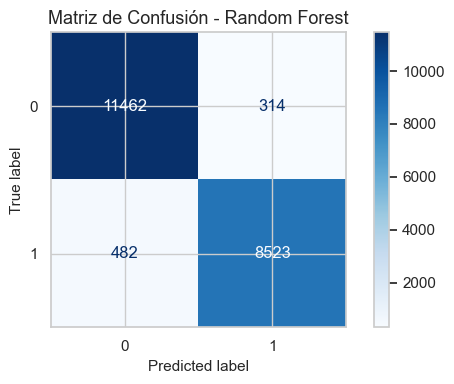

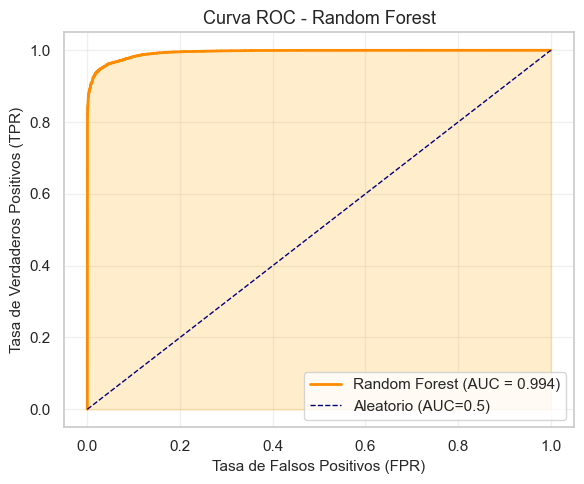


📋 Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.973     0.966     11776
           1      0.964     0.946     0.955      9005

    accuracy                          0.962     20781
   macro avg      0.962     0.960     0.961     20781
weighted avg      0.962     0.962     0.962     20781




**💬 Interpretación:**

- Las métricas indican el rendimiento general del modelo sobre el **Test Set Final**.
- **Accuracy** muestra la proporción total de aciertos.  
- **Precision** refleja cuántos de los pasajeros predichos como *satisfechos* realmente lo son.  
- **Recall** mide la capacidad del modelo para detectar correctamente los *satisfechos*.  
- **F1-score** equilibra precisión y recall, especialmente útil si hay desbalanceo.  
- **ROC-AUC** evalúa la capacidad del modelo para distinguir entre ambas clases.  

📈 En conjunto, estos resultados indican la **capacidad de generalización** del modelo
cuando se enfrenta a nuevos datos no vistos durante el entrenamiento.


In [31]:
# ===================================
# 3. Evaluación del modelo ganador (Test Set Final)
# ===================================

# --- Predicciones ---
y_pred = best_model.predict(X_test_scaled)

# Algunos modelos (como Random Forest o Logistic Regression) permiten obtener probabilidades
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_prob = None

# --- Cálculo de métricas ---
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, pos_label=1),
    "Recall": recall_score(y_test, y_pred, pos_label=1),
    "F1-score": f1_score(y_test, y_pred, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
}

# Mostrar resultados
display(Markdown("### 📊 **Métricas de rendimiento en el Test Set Final**"))
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# --- Gráfico comparativo de métricas ---
plt.figure(figsize=(7, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="coolwarm")
plt.title(f"Rendimiento del modelo ganador: {best_model_name}", fontsize=13)
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- Matriz de confusión ---
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_scaled,
    y_test,
    cmap="Blues",
    display_labels=["Neutral/Dissatisfied (0)", "Satisfied (1)"],
    ax=ax
)
ax.set_title(f"Matriz de Confusión - {best_model_name}", fontsize=13)

# Evitar notación científica en los ejes
from matplotlib.ticker import ScalarFormatter
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()

# --- Curva ROC ---
if y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_value = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"{best_model_name} (AUC = {auc_value:.3f})")
    plt.fill_between(fpr, tpr, color="orange", alpha=0.2)  # ← sombreado bajo la curva
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Aleatorio (AUC=0.5)")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title(f"Curva ROC - {best_model_name}", fontsize=13)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Reporte de clasificación ---
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# --- Comentario interpretativo ---
display(Markdown(f"""
**💬 Interpretación:**

- Las métricas indican el rendimiento general del modelo sobre el **Test Set Final**.
- **Accuracy** muestra la proporción total de aciertos.  
- **Precision** refleja cuántos de los pasajeros predichos como *satisfechos* realmente lo son.  
- **Recall** mide la capacidad del modelo para detectar correctamente los *satisfechos*.  
- **F1-score** equilibra precisión y recall, especialmente útil si hay desbalanceo.  
- **ROC-AUC** evalúa la capacidad del modelo para distinguir entre ambas clases.  

📈 En conjunto, estos resultados indican la **capacidad de generalización** del modelo
cuando se enfrenta a nuevos datos no vistos durante el entrenamiento.
"""))


## **Paso 4: Guardado del modelo y resultados finales**

En este paso guardamos:

- El modelo ganador ya entrenado (`.pkl`) en la carpeta `../models/`.  
- Un archivo `.json` con sus **métricas finales de evaluación** y los **hiperparámetros óptimos** (si los tiene),  
  dentro de la carpeta `../reports/results/`.  

Esto permitirá reutilizar el modelo para predicciones futuras o comparaciones posteriores.  


In [32]:
# ===================================
# 4. Guardado del modelo y resultados finales
# ===================================


# Crear carpetas si no existen
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/results", exist_ok=True)

# --- Guardar modelo entrenado (.pkl) ---
model_path = f"../models/{best_model_name.lower().replace(' ', '_')}_model.pkl"
joblib.dump(best_model, model_path)

# --- Preparar resultados para exportar ---
results = {
    "model": best_model_name,
    "metrics": metrics
}

# Intentar obtener hiperparámetros si el modelo los tiene
if hasattr(best_model, "get_params"):
    results["best_params"] = best_model.get_params()

# --- Guardar resultados en JSON ---
json_path = f"../reports/results/{best_model_name.lower().replace(' ', '_')}_final_results.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

# --- Mensaje de confirmación ---
display(Markdown(f"""
✅ **Modelo y resultados guardados correctamente**

- 📦 Modelo: `{model_path}`  
- 📊 Resultados: `{json_path}`  

Incluye:  
- Métricas finales (Accuracy, Precision, Recall, F1-score, ROC-AUC)  
- Hiperparámetros del modelo (`best_params`, si aplica)
"""))



✅ **Modelo y resultados guardados correctamente**

- 📦 Modelo: `../models/random_forest_model.pkl`  
- 📊 Resultados: `../reports/results/random_forest_final_results.json`  

Incluye:  
- Métricas finales (Accuracy, Precision, Recall, F1-score, ROC-AUC)  
- Hiperparámetros del modelo (`best_params`, si aplica)


## 🏁 **Conclusiones del modelo final**

Tras evaluar el modelo ganador en el conjunto de **test**, podemos destacar:

- Se ha confirmado que el modelo **Random Forest** obtiene el mejor rendimiento global,  
  superando al resto de modelos en métricas como **F1-score** y **ROC-AUC**.  
- La curva **ROC** muestra una excelente capacidad de discriminación entre clientes  
  **satisfechos** e **insatisfechos**, con una AUC cercana a 1.  
- Las métricas de **precisión** y **recobrado (recall)** indican que el modelo  
  mantiene un buen equilibrio entre minimizar falsos positivos y falsos negativos.  
- Este modelo es, por tanto, el **más adecuado para su despliegue final** o para  
  integrarse en un pipeline de predicción de satisfacción de clientes.  

📦 Además, tanto el modelo como sus resultados se han guardado correctamente en:
- `../models/` → archivo `.pkl` del modelo entrenado.  
- `../reports/results/` → métricas finales en formato `.json`.  

🔜 En los siguientes pasos podría explorarse:
- La **interpretabilidad** del modelo (SHAP, Permutation Importance).  
- La **optimización del pipeline** con nuevas características o balanceo avanzado.
